In [112]:
import sys
sys.path.append("../Simulations/")

from units import *
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.special import erf, jn, jv

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Enclosed mass $M(b)$

In [414]:
from skmonaco import mcquad
from math import sqrt
result, error = mcquad(lambda xs: sqrt(xs[0]**2+xs[1]**2+xs[2]**2), npoints=1e6, xl=[0.,0.,0.], xu=[1.,1.,1.])
print( "{} +/- {}".format(result,error))

0.960572566164358 +/- 0.00027796733594467345


In [255]:
def c200_get(m200):
    """ Virial concentration according to Sanchez-Conde&Prada14
    """
    x=mpmath.log(m200*h) # Given in terms of M_s/h in S-C&P paper
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

def rho_nfw(r):
    """Unnormalized NFW profile density"""
    return 1/((r/r_s)*(1+r/r_s)**2)

In [256]:
m200 = 1e7*M_s

c200 = c200_get(m200/M_s)
r200 = (m200/(4/3.*np.pi*200*rho_c))**(1/3.)
r_s = r200/c200
rho_s = rho_c*(200/3.)*c200**3/(mpmath.log(1 + c200) - c200/(1 + c200))

In [375]:
def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341
    """
    if x > 1:
        return mpmath.atan(np.sqrt(x**2-1))/(np.sqrt(x**2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return mpmath.atanh(np.sqrt(1-x**2))/(np.sqrt(1-x**2))

def M_nfw(r):
    kappa_s = rho_s*r_s
    x = r/r_s
    phi_r = 4*kappa_s*r_s*(np.log(x/2) + F(x))/x
    return phi_r*np.pi*r

def M_gauss(r, M0, R0):
    return M0*(1-np.exp(-r**2/(2*R0**2)))

In [376]:
import mpmath

In [411]:
D_l = 10*kpc
l_ary = np.linspace(1,200, 20)


Cl_ary = np.array([quad(lambda theta: mpmath.j1(l*theta), 0, 2*np.pi) \
                   for l in tqdm_notebook(l_ary)])

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [436]:
from skmonaco import mcquad, mcimport

In [444]:
Cl_ary = np.array([mcquad(lambda theta: jv(1,l*theta), npoints=1e7, xl=[0.], xu=[np.pi], nprocs=12) \
                   for l in tqdm_notebook(l_ary)])

In [445]:
Cl_ary

array([[[1.30419867e+00],
        [1.56642428e-04]],

       [[9.64180322e-02],
        [1.89669768e-04]],

       [[4.30192945e-02],
        [1.48817456e-04]],

       [[2.89335564e-02],
        [1.27336575e-04]],

       [[2.41319225e-02],
        [1.13614984e-04]],

       [[1.97061993e-02],
        [1.03829659e-04]],

       [[1.54943074e-02],
        [9.64609683e-05]],

       [[1.27224625e-02],
        [9.05177158e-05]],

       [[1.18671234e-02],
        [8.57194930e-05]],

       [[1.10456960e-02],
        [8.16937710e-05]],

       [[9.50600547e-03],
        [7.81075315e-05]],

       [[8.25570737e-03],
        [7.50577116e-05]],

       [[7.91621228e-03],
        [7.24132953e-05]],

       [[7.51066618e-03],
        [6.99587749e-05]],

       [[6.89708483e-03],
        [6.77751102e-05]],

       [[6.19968634e-03],
        [6.59528499e-05]],

       [[5.76757772e-03],
        [6.41637154e-05]],

       [[5.76326788e-03],
        [6.24234939e-05]],

       [[5.49531183e-03],
  

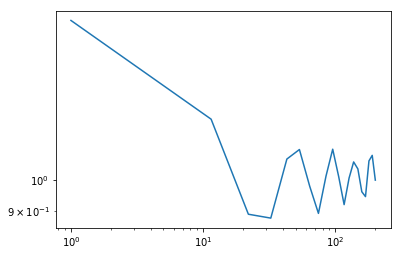

In [447]:
plt.plot(l_ary, l_ary**2*Cl_ary[:,0,0]**2)
plt.xscale("log")
plt.yscale("log")

In [127]:
def Cl_Gauss(R0, M0, Dl, v, lmin, lmax):
    beta0 = R0/Dl
    l_ary = np.arange(lmin, lmax)
    return np.array([(4*GN*M0*v/Dl**2)**2*np.pi/2.*np.exp(-l**2*beta0**2) for l in l_ary])

def cov_mat(ell, C_l, N_l, fsky=0.5):
    return 1/((2*ell+1)*fsky)*(2*(C_l + N_l)**2)

def likelihood(C_l_data, C_l_theta, cov_mat_theta):
    dC_l_theta = np.sqrt(cov_mat_theta)
    return np.sum(-0.5*((C_l_data - C_l_theta)/dC_l_theta)**2)

In [3]:
l_min = 1
l_max = 200
l_ary = np.arange(l_min, l_max)

sigma_mu = 1 # in muas/yr
N0 = 1e8
N_l = np.ones_like(l_ary)*sigma_mu**2/N0

In [4]:
# Fix units of signal prediction
C_l /= (1e-6*asctorad/Year)**2

NameError: name 'C_l' is not defined

(-5, 5)

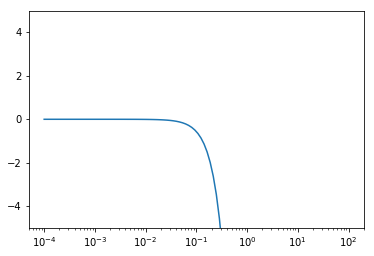

In [6]:
LL=[]
frac_scale = np.logspace(-4,2,100)
for i in frac_scale:
    LL.append(2*likelihood(N_l, i*C_l + N_l, cov_mat(l_ary, i*C_l, N_l)))
    
plt.plot(frac_scale, LL)
plt.xscale("log")
plt.ylim(-5,5)

In [80]:
# Cl_Gauss(10*pc, 10**8*M_s, 10*kpc, 1e-3, 1, 2)[0] / (1e-6*asctorad/Year)**2

In [98]:
def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return 1/((r/r_s)*(1+r/r_s)**2)

def rho_v(v):
    """Unnormalized SHM Maxwellian"""
    v0 = 220*Kmps
    if v > 550*Kmps: return 0
    return np.exp(-v**2/v0**2)

Rsun = 8*kpc
Rmin = 3*kpc
Rmax = 100*kpc
R0 = 10*pc
M0 = 10**8*M_s

In [99]:
v0 = 220.*Kmps
vesc = 544.*Kmps
vsun = (11.*Kmps, 12.*Kmps + v0, 7.*Kmps)

Nesc = erf(vesc/v0) - 2/np.sqrt(np.pi)*vesc/v0*np.exp(-vesc**2/v0**2)

def fG(vvec):
    v = np.linalg.norm(vvec)
    return 1/(Nesc*np.pi**1.5*v0**3)*np.exp(-v**2/v0**2)*(v < vesc)

In [111]:
DM_frac = 0.1
N_halos = DM_frac*1/(M0/(10**12*M_s))

In [101]:
norm = nquad(lambda l, theta: rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])[0]

In [126]:
# conv = [nquad(lambda l, theta: Cl_Gauss(R0, M0, l, 1, l_lo, l_lo+1)[0] / (1e-6*asctorad/Year)**2  * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]]) for l_lo in tqdm(range(l_min, l_max))]


In [103]:
conv = [nquad(lambda l, theta: Cl_Gauss(R0, M0, l, 1, l_lo, l_lo+1)[0] / (1e-6*asctorad/Year)**2  * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]]) for l_lo in tqdm(range(l_min, l_max))]

In [92]:
integ, err = nquad(lambda v, theta, phi: v**4*np.sin(theta)*fG(v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) + vsun),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])
v_term = integ

In [118]:
N_halos*np.array(conv)[:,0] / norm * v_term

array([9.36321137e-08])

In [136]:
l_min = 1
l_max = 200
l_ary = np.arange(l_min, l_max)

sigma_mu = 10 # in muas/yr
N0 = 0.0001e9*4*np.pi
N_l = np.ones_like(l_ary)*sigma_mu**2/N0

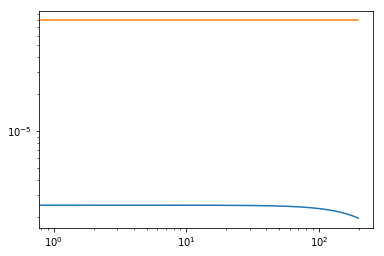

In [137]:
plt.plot(N_halos*np.array(conv)[:,0] / norm * v_term)
plt.plot(N_l)

plt.xscale("log")
plt.yscale("log")